In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np
import pickle
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import f1_score

In [2]:
def macro_f1_score(y_true, y_pred):
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return macro_f1

In [3]:
labelsPath = '../data/labels_pd_pickle'
file = open(labelsPath,'rb')
data = pickle.load(file)

data.drop(columns=['text_ocr'])


taskA = data.take([0,2,7],axis=1)

one_hot_encoded = pd.get_dummies(taskA['overall_sentiment'],dtype=int)
taskA['ohe'] = one_hot_encoded.values.tolist()
labels = one_hot_encoded.columns.tolist()
taskA['text_corrected'] = taskA['text_corrected'].astype('string')
codes, uniques = pd.factorize(taskA['overall_sentiment'])
taskA['class'] = codes


print(taskA['class'].value_counts())
taskAbalanced = pd.concat([
    taskA[taskA['class'] == c].sample(n=151, replace=True) for c in taskA['class'].unique()
])
print(taskAbalanced['class'].value_counts())

taskAbalanced = taskAbalanced.sample(frac=1).reset_index(drop=True)

taskAbalanced.head()


1    3127
2    2201
0    1033
3     480
4     151
Name: class, dtype: int64
4    151
3    151
2    151
1    151
0    151
Name: class, dtype: int64


,image_name,text_corrected,overall_sentiment,ohe,class
0,image_1168.jpeg,We Can Do It! RADICAL FEMINISM It's no longer ...,neutral,"[0, 1, 0, 0, 0]",2
1,image_6861.jpg,FROGMAN? NICE NICKNAME Quickmeme.com,very_positive,"[0, 0, 0, 0, 1]",0
2,image_6428.png,I'VE WATCHED THE WALKING DEAD ENOUGH TO KNOW H...,negative,"[1, 0, 0, 0, 0]",3
3,image_6632.jpg,Iceland President “The government bailed out t...,very_negative,"[0, 0, 0, 1, 0]",4
4,image_3608.jpg,VOTE FOR MY WIFE TRUMP IS SEXIST,very_negative,"[0, 0, 0, 1, 0]",4


In [4]:
taskAbalanced['overall_sentiment'].unique()

array(['neutral', 'very_positive', 'negative', 'very_negative',
       'positive'], dtype=object)

In [5]:
images_folder = '../data/images/'
images = []
df = taskAbalanced
for filename in df['image_name'].values:  # Zmień 'nazwa_pliku' na nazwę kolumny z nazwami plików w DataFrame
    img = Image.open(images_folder + filename)  # Tworzenie ścieżki do pliku obrazu
    img = img.resize((224, 224))  # Dopasowanie rozmiaru obrazu, jeśli to konieczne
    img = img.convert('RGB')  # Konwertuj do formatu RGB
    img_array = np.array(img)  # Konwersja obrazu PIL na tablicę numpy
    img_array = preprocess_input(img_array)
    images.append(img_array)  # Dodanie obrazu do listy
images = np.stack(images)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [6]:
images[:].shape

(755, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


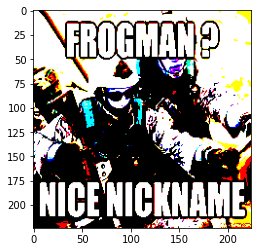

image_name                                 image_6861.jpg
text_corrected       FROGMAN? NICE NICKNAME Quickmeme.com
overall_sentiment                           very_positive
ohe                                       [0, 0, 0, 0, 1]
class                                                   0
Name: 1, dtype: object

In [7]:
import matplotlib.pyplot as plt
plt.imshow(images[1])
plt.show()
df.iloc[1]

In [8]:
# from sklearn.model_selection import train_test_split

# Xtrain, Xtest, ytrain, ytest = train_test_split(df['text_corrected'],df['class'],shuffle=False)
# Xtrain = np.asarray(Xtrain).astype(np.str)
# ytrain = np.asarray(ytrain).astype(np.int)
# Xtest = np.asarray(Xtest).astype(np.str)
# ytest = np.asarray(ytest).astype(np.int)

from sklearn.model_selection import KFold

kf = KFold(n_splits=5,shuffle=True, random_state=777)

trainFolds={}
testFolds={}

for i, (train_index, test_index) in enumerate(kf.split(df['text_corrected'])):
    trainFolds[i] = (df['text_corrected'][train_index].reset_index(drop=True),images[train_index], df['class'][train_index].reset_index(drop=True))
    testFolds[i]  = (df['text_corrected'][test_index].reset_index(drop=True),images[test_index] ,  df['class'][test_index].reset_index(drop=True))
    

In [9]:
def foldProccess(i,Xtrain, Xtest, ytrain, ytest, imagesTrain, imagesTest):    
    bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
    base_model = ResNet50(weights='imagenet', include_top=False)
    for layer in base_model.layers:
        layer.trainable = False
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    bertOutputs = bert_encoder(preprocessed_text)
    l = tf.keras.layers.Dropout(0.1, name="dropout")(bertOutputs['pooled_output'])
    #ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    #HEAD
    concatenated = concatenate([x, l])
    connect = Dense(512, activation='relu')(concatenated)
    l = tf.keras.layers.Dense(5, activation='softmax', name="output")(connect)
    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input,base_model.input], outputs = [l])
    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
        tf.keras.metrics.SparseCategoricalCrossentropy()
    ]
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=METRICS)
    
    
    
    history = model.fit([Xtrain,imagesTrain], ytrain, epochs=15,validation_split=0.1)#, callbacks=[early_stopping])
    model.save(f'models/cross4/{i}_multimod_bert_res50_e15_val0_1')
    model.evaluate([Xtest, imagesTest], ytest)
    ypred = model.predict([Xtest, imagesTest])
    z = np.argmax(ypred, axis=1)
    macro_f1 = macro_f1_score(ytest, z)
    print("Macro F1 Score:", macro_f1)

In [10]:
for i in range(0,5)[:]:
    Xtrain, imagesTrain, ytrain = trainFolds[i][0], trainFolds[i][1], trainFolds[i][2] 
    Xtest, imagesTest, ytest = testFolds[i][0], testFolds[i][1], testFolds[i][2]
    foldProccess(i,Xtrain,  Xtest, ytrain, ytest, imagesTrain, imagesTest)

Epoch 1/15
17/17 [==============================] - 119s 7s/step - loss: 2.5392 - sparse_categorical_accuracy: 0.2081 - sparse_categorical_crossentropy: 2.5392 - val_loss: 1.8209 - val_sparse_categorical_accuracy: 0.1803 - val_sparse_categorical_crossentropy: 1.8209
Epoch 2/15
17/17 [==============================] - 104s 6s/step - loss: 1.5280 - sparse_categorical_accuracy: 0.3241 - sparse_categorical_crossentropy: 1.5280 - val_loss: 1.5900 - val_sparse_categorical_accuracy: 0.3443 - val_sparse_categorical_crossentropy: 1.5900
Epoch 3/15
17/17 [==============================] - 101s 6s/step - loss: 1.3253 - sparse_categorical_accuracy: 0.4438 - sparse_categorical_crossentropy: 1.3253 - val_loss: 1.7421 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.7421
Epoch 4/15
17/17 [==============================] - 99s 6s/step - loss: 1.0789 - sparse_categorical_accuracy: 0.5838 - sparse_categorical_crossentropy: 1.0789 - val_loss: 1.6789 - val_sparse_categori

INFO:tensorflow:Assets written to: models/cross4/0_multimod_bert_res50_e15_val0_1/assets


INFO:tensorflow:Assets written to: models/cross4/0_multimod_bert_res50_e15_val0_1/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 24s 5s/step - loss: 3.2252 - sparse_categorical_accuracy: 0.2517 - sparse_categorical_crossentropy: 3.2252
Macro F1 Score: 0.24639517680799009
Epoch 1/15
17/17 [==============================] - 116s 7s/step - loss: 2.8971 - sparse_categorical_accuracy: 0.2063 - sparse_categorical_crossentropy: 2.8971 - val_loss: 1.6258 - val_sparse_categorical_accuracy: 0.2459 - val_sparse_categorical_crossentropy: 1.6258
Epoch 2/15
17/17 [==============================] - 114s 7s/step - loss: 1.6219 - sparse_categorical_accuracy: 0.2615 - sparse_categorical_crossentropy: 1.6219 - val_loss: 1.5833 - val_sparse_categorical_accuracy: 0.2623 - val_sparse_categorical_crossentropy: 1.5833
Epoch 3/15
17/17 [==============================] - 105s 6s/step - loss: 1.4172 - sparse_categorical_accuracy: 0.3904 - sparse_categorical_crossentropy: 1.4172 - val_loss: 1.5793 - val_sparse_categorical_accuracy: 0.2787 - val_sparse_categorical_crossentropy: 1.5793
Epoch 4/15
17/17 

INFO:tensorflow:Assets written to: models/cross4/1_multimod_bert_res50_e15_val0_1/assets


INFO:tensorflow:Assets written to: models/cross4/1_multimod_bert_res50_e15_val0_1/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 25s 5s/step - loss: 3.2580 - sparse_categorical_accuracy: 0.3841 - sparse_categorical_crossentropy: 3.2580
Macro F1 Score: 0.38286785009274527
Epoch 1/15
17/17 [==============================] - 106s 6s/step - loss: 3.0340 - sparse_categorical_accuracy: 0.1805 - sparse_categorical_crossentropy: 3.0340 - val_loss: 1.8588 - val_sparse_categorical_accuracy: 0.1967 - val_sparse_categorical_crossentropy: 1.8588
Epoch 2/15
17/17 [==============================] - 97s 6s/step - loss: 1.6058 - sparse_categorical_accuracy: 0.2873 - sparse_categorical_crossentropy: 1.6058 - val_loss: 1.6752 - val_sparse_categorical_accuracy: 0.1967 - val_sparse_categorical_crossentropy: 1.6752
Epoch 3/15
17/17 [==============================] - 95s 6s/step - loss: 1.4812 - sparse_categorical_accuracy: 0.3333 - sparse_categorical_crossentropy: 1.4812 - val_loss: 1.7385 - val_sparse_categorical_accuracy: 0.1639 - val_sparse_categorical_crossentropy: 1.7385
Epoch 4/15
17/17 [=

INFO:tensorflow:Assets written to: models/cross4/2_multimod_bert_res50_e15_val0_1/assets


INFO:tensorflow:Assets written to: models/cross4/2_multimod_bert_res50_e15_val0_1/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 27s 5s/step - loss: 3.0659 - sparse_categorical_accuracy: 0.3642 - sparse_categorical_crossentropy: 3.0659
Macro F1 Score: 0.3496892655367232
Epoch 1/15
17/17 [==============================] - 115s 6s/step - loss: 2.5363 - sparse_categorical_accuracy: 0.1860 - sparse_categorical_crossentropy: 2.5363 - val_loss: 1.5357 - val_sparse_categorical_accuracy: 0.3115 - val_sparse_categorical_crossentropy: 1.5357
Epoch 2/15
17/17 [==============================] - 102s 6s/step - loss: 1.5523 - sparse_categorical_accuracy: 0.3002 - sparse_categorical_crossentropy: 1.5523 - val_loss: 1.7782 - val_sparse_categorical_accuracy: 0.1639 - val_sparse_categorical_crossentropy: 1.7782
Epoch 3/15
17/17 [==============================] - 98s 6s/step - loss: 1.3956 - sparse_categorical_accuracy: 0.4254 - sparse_categorical_crossentropy: 1.3956 - val_loss: 1.6450 - val_sparse_categorical_accuracy: 0.3770 - val_sparse_categorical_crossentropy: 1.6450
Epoch 4/15
17/17 [=

INFO:tensorflow:Assets written to: models/cross4/3_multimod_bert_res50_e15_val0_1/assets


INFO:tensorflow:Assets written to: models/cross4/3_multimod_bert_res50_e15_val0_1/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 27s 5s/step - loss: 3.0634 - sparse_categorical_accuracy: 0.3642 - sparse_categorical_crossentropy: 3.0634
Macro F1 Score: 0.3665569056427265
Epoch 1/15
17/17 [==============================] - 119s 7s/step - loss: 2.9024 - sparse_categorical_accuracy: 0.1952 - sparse_categorical_crossentropy: 2.9024 - val_loss: 1.6889 - val_sparse_categorical_accuracy: 0.2951 - val_sparse_categorical_crossentropy: 1.6889
Epoch 2/15
17/17 [==============================] - 108s 6s/step - loss: 1.6007 - sparse_categorical_accuracy: 0.2855 - sparse_categorical_crossentropy: 1.6007 - val_loss: 1.6486 - val_sparse_categorical_accuracy: 0.2131 - val_sparse_categorical_crossentropy: 1.6486
Epoch 3/15
17/17 [==============================] - 107s 6s/step - loss: 1.4233 - sparse_categorical_accuracy: 0.3812 - sparse_categorical_crossentropy: 1.4233 - val_loss: 1.5669 - val_sparse_categorical_accuracy: 0.3443 - val_sparse_categorical_crossentropy: 1.5669
Epoch 4/15
17/17 [

INFO:tensorflow:Assets written to: models/cross4/4_multimod_bert_res50_e15_val0_1/assets


INFO:tensorflow:Assets written to: models/cross4/4_multimod_bert_res50_e15_val0_1/assets
/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


5/5 [==============================] - 26s 5s/step - loss: 2.6898 - sparse_categorical_accuracy: 0.3444 - sparse_categorical_crossentropy: 2.6898
Macro F1 Score: 0.340441939467593


In [ ]:
model.save('models/multimod_bert_res50_v7_e18_val0_1')

In [ ]:
model.evaluate([Xtest, images[566:]], ytest)

In [ ]:
ypred = model.predict([Xtest, images[566:]])
z = np.argmax(ypred, axis=1)

In [ ]:
macro_f1 = macro_f1_score(ytest, z)
print("Macro F1 Score:", macro_f1)

In [ ]:
history.history

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Wyświetlenie wartości straty dla zbioru treningowego i walidacyjnego
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['sparse_categorical_crossentropy'], label='sparse_categorical_crossentropy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epoch')
    plt.legend()
    plt.show()
    
    # Wyświetlenie wartości dokładności dla zbioru treningowego i walidacyjnego
    #plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_sparse_categorical_crossentropy'], label='val_sparse_categorical_crossentropy')
    plt.xlabel('Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.legend()
    plt.show()
plot_history(history)